In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np
import libpysal as lps
import seaborn as sns
import libpysal as lps
import pysal as ps
from libpysal.weights import Queen, Rook, KNN
from shapely import wkt
from scipy.spatial import cKDTree
import sklearn.model_selection as model_select
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from libpysal import weights
try:
    from scipy.optimize import minimize_scalar
    minimize_scalar_available = True
except ImportError:
    minimize_scalar_available = False
import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
#sorghum residue
rice18=pd.read_csv("dataset/production/Rice_2018.csv",usecols=["Area Code (FAO)","Rice_Residue"])

In [5]:
rice18.isnull().sum()

Area Code (FAO)    0
Rice_Residue       0
dtype: int64

In [6]:
#read country code
country_code=pd.read_csv("dataset/country_data.csv",usecols=["Country Code","Country","ISO2 Code","ISO3 Code"])
country_code.head()

,Country Code,Country,ISO2 Code,ISO3 Code
0,2,Afghanistan,AF,AFG
1,5100,Africa,NaN,X06
2,3,Albania,AL,ALB
3,4,Algeria,DZ,DZA
4,5,American Samoa,AS,ASM


In [7]:
#country area
area=pd.read_csv("dataset/cropland/country_area.csv",usecols=["country_area","ISO3 Code"])
area.head()

,ISO3 Code,country_area
0,ABW,180.0
1,AFG,652860.0
2,AGO,1246700.0
3,ALB,28750.0
4,AND,470.0


In [8]:
#read shapefile
poly=gpd.read_file("dataset/wb_countries_admin0_10m/wb_countries_admin0_10m.shp")
poly.columns

Index(['OBJECTID', 'featurecla', 'LEVEL', 'TYPE', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10_', 'ISO_A2', 'ISO_A3',
       'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'CONTINENT',
       'REGION_UN', 'SUBREGION', 'REGION_WB', 'NAME_AR', 'NAME_BN', 'NAME_DE',
       'NAME_EN', 'NAME_ES', 'NAME_FR', 'NAME_EL', 'NAME_HI', 'NAME_HU',
       'NAME_ID', 'NAME_IT', 'NAME_JA', 'NAME_KO', 'NAME_NL', 'NAME_PL',
       'NAME_PT', 'NAME_RU', 'NAME_SV', 'NAME_TR', 'NAME_VI', 'NAME_ZH',
       'WB_NAME', 'WB_RULES', 'WB_REGION', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

In [9]:
poly.loc[50,"ISO_A3_EH"]="NOR"

In [10]:
#merge country code and shapefile
country_poly=pd.merge(country_code,poly,left_on="ISO3 Code",right_on="ISO_A3_EH",how="inner")
country_poly.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afghanistan,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Albanien,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158..."
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Algeriet,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ..."
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikanska Samoa,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576..."
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ..."


In [11]:
country_poly1=pd.merge(country_poly,area,on="ISO3 Code",how="outer")
country_poly1.head()

,Country Code,Country,ISO2 Code,ISO3 Code,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,...,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry,country_area
0,2,Afghanistan,AF,AFG,126,Admin-0 country,2,Sovereign country,Islamic State of Afghanistan,None,...,Afganistan,Afghanistan,阿富汗,Afghanistan,None,SOA,52.765827,62.591664,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",652860.0
1,3,Albania,AL,ALB,61,Admin-0 country,2,Sovereign country,Republic of Albania,None,...,Arnavutluk,Albania,阿尔巴尼亚,Albania,None,ECA,11.050457,3.039395,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",28750.0
2,4,Algeria,DZ,DZA,118,Admin-0 country,2,Sovereign country,People's Democratic Republic of Algeria,None,...,Cezayir,Algérie,阿尔及利亚,Algeria,None,MENA,71.641687,212.690941,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",2381741.0
3,5,American Samoa,AS,ASM,228,Admin-0 country,2,Dependency,American Samoa,None,...,Amerikan Samoası,Samoa thuộc Mỹ,美屬薩摩亞,American Samoa (US),Name in italic,Other,1.073705,0.015101,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",200.0
4,6,Andorra,AD,AND,125,Admin-0 country,2,Sovereign country,Principality of Andorra,None,...,Andorra,Andorra,安道尔,Andorra,None,Other,1.057953,0.049561,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",470.0


In [12]:
#select columns
country_poly1=pd.DataFrame(country_poly1,columns=["Country Code","Country","geometry","CONTINENT","country_area"])
country_poly1.head()

,Country Code,Country,geometry,CONTINENT,country_area
0,2,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,652860.0
1,3,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,28750.0
2,4,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2381741.0
3,5,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,200.0
4,6,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,470.0


In [13]:
rice18_g=pd.merge(country_poly1,rice18,left_on="Country Code",right_on="Area Code (FAO)",how="outer")
rice18_g=gpd.GeoDataFrame(rice18_g)
rice18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00


In [14]:
rice18_g=rice18_g.drop([227,228])

Text(0.5, 1, 'Rice Residues (2018)')

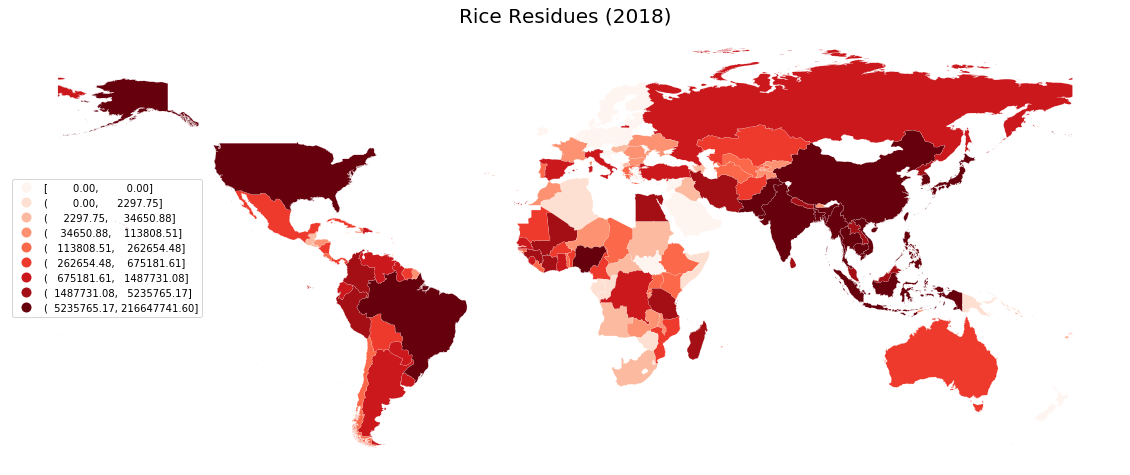

In [15]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
rice18_g.plot(column='Rice_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Rice Residues (2018)", fontsize=20)

In [16]:
#fill missing values
#get centriod of each polygon
rice18_g["centroid"]=rice18_g["geometry"].values.centroid

In [17]:
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([rice18_g.loc[i,"centroid"].x,rice18_g.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=8)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(rice18_g.loc[j,"Rice_Residue"]):
                k=k+1
                sum_r=sum_r+rice18_g.loc[j,"Rice_Residue"]
        if k!=0:
            a_sum=sum_r/k
            rice18_g.loc[i,"Rice_Residue"]=a_sum

while len(rice18_g[np.isnan(rice18_g["Rice_Residue"].values)].index)!=0:
    ckdnearest(rice18_g,rice18_g[np.isnan(rice18_g["Rice_Residue"].values)].index)

In [18]:
len(rice18_g[np.isnan(rice18_g["Rice_Residue"].values)])

0

Text(0.5, 1, 'Rice Residues (2018)')

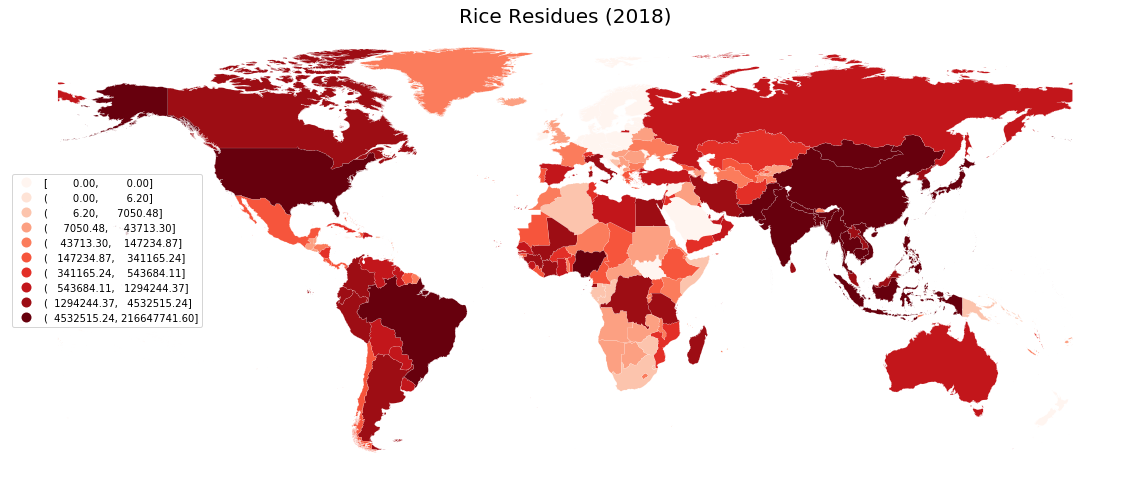

In [19]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
rice18_g.plot(column='Rice_Residue',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
         )
ax.set_axis_off()
ax.set_title("Rice Residues (2018)", fontsize=20)

In [20]:
rice18_g["Area Code (FAO)"]=rice18_g["Country Code"]
rice18_g

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627)
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248)
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889)
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494)
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133)
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232)
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569)
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438)
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755)
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813)


In [21]:
#do spatial analysis
#global spatial analysis
rice18_gs=rice18_g
rice_binary=[]
for i in range(0,rice18_gs.shape[0]):
    rice_binary.append(rice18_gs.loc[i,'Rice_Residue']> rice18_gs['Rice_Residue'].median())

In [22]:
labels = ['Low value', 'High value']
rice_binary= [labels[i] for i in 1*rice_binary] 
rice18_gs['Rice_binary'] = rice_binary

Text(0.5, 1, 'High and Low Values of Rice Residues (2018)')

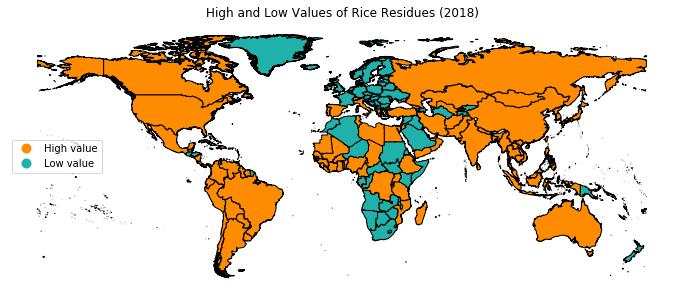

In [23]:
#visualize high and low values
from matplotlib import colors
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
cmap = colors.ListedColormap(['darkorange', 'lightseagreen'])  
rice18_gs.plot(column='Rice_binary', cmap=cmap ,edgecolor='black', legend=True,legend_kwds=dict(loc='center left'), ax=ax)
ax.set_axis_off()
ax.set_title("High and Low Values of Rice Residues (2018)")

In [24]:
#global autocorrelation
from pysal.explore import esda 
rice_18gx_binary = 1 * (rice18_gs['Rice_Residue']>rice18_gs['Rice_Residue'].median()) # convert back to binary
rice_W_queen = lps.weights.Queen.from_dataframe(rice18_gs)
rice_W_queen.transform = 'b'
rice_jc = esda.join_counts.Join_Counts(rice_18gx_binary,rice_W_queen)

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

Text(0.5, 0, "Moran's I")

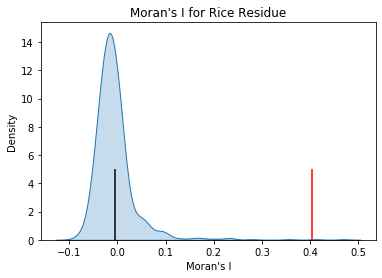

In [25]:
rice_mi = esda.moran.Moran(rice18_gs['Rice_Residue'],rice_W_queen)
sns.kdeplot(rice_mi.sim, shade=True)
plt.vlines(rice_mi.I, 0, 5, color='r')
plt.vlines(rice_mi.EI, 0, 5)
plt.title("Moran's I for Rice Residue")
plt.xlabel("Moran's I")

In [26]:
# Check the statistical significance
rice_mi.p_sim

0.003

In [27]:
rice_w_queen = Queen.from_dataframe(rice18_gs) 

In [28]:
I_price = ps.explore.esda.Moran(rice18_gs['Rice_Residue'].values, rice_w_queen)  # Moran's I
I_price.I, I_price.p_sim 

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('W

(0.40346069124221634, 0.004)

In [29]:
#local spatial autocorrelation
rice_lisa = ps.explore.esda.Moran_Local(rice18_gs['Rice_Residue'].values,rice_w_queen, permutations=999)

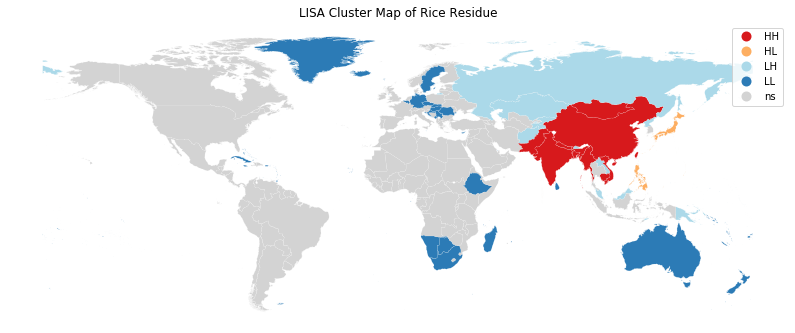

In [30]:
from pysal.viz.splot.esda import lisa_cluster
fig, ax=plt.subplots(1, figsize=(14,10))
fig = lisa_cluster(rice_lisa,rice18_gs, ax=ax)
plt.title("LISA Cluster Map of Rice Residue")
plt.show() 

In [31]:
rice18_gs['lag_rice'] = ps.lib.weights.lag_spatial(rice_W_queen, rice18_gs['Rice_Residue'])
sigs = rice18_gs['Rice_Residue'][rice_lisa.p_sim <= .05]
W_sigs = rice18_gs['lag_rice'][rice_lisa.p_sim <= .05]
insigs = rice18_gs['Rice_Residue'][rice_lisa.p_sim > .05]
W_insigs = rice18_gs['lag_rice'][rice_lisa.p_sim > .05]

Text(0.5, 0, 'Rice Value(2018)')

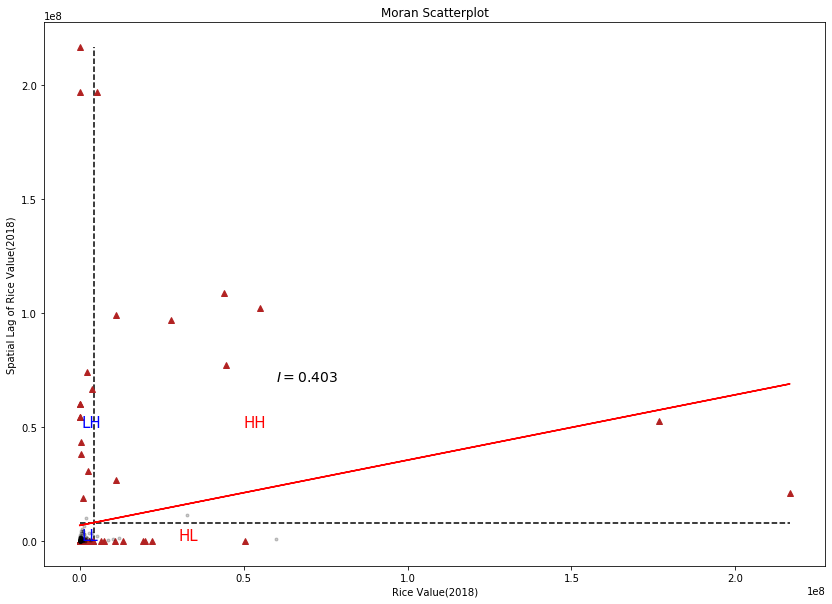

In [32]:
b,a = np.polyfit(rice18_gs['Rice_Residue'], rice18_gs['lag_rice'], 1)
moran=ps.explore.esda.Moran(rice18_gs['Rice_Residue'].values, rice_W_queen)

fig, ax=plt.subplots(1, figsize=(14,10))
plt.plot(sigs, W_sigs, '^', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(rice18_gs['Rice_Residue'].mean(), rice18_gs['lag_rice'].min(), rice18_gs['lag_rice'].max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(rice18_gs['lag_rice'].mean(), rice18_gs['Rice_Residue'].min(), rice18_gs['Rice_Residue'].max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(rice18_gs['Rice_Residue'], a + b*rice18_gs['Rice_Residue'], 'r')
plt.text(s='$I = %.3f$' % moran.I, x=60000000, y=70000000, fontsize=14)
plt.text(50000000, 50000000, "HH", fontsize=15, color='r')
plt.text(30000000, 400000, "HL", fontsize=15, color='r')
plt.text(400000,50000000, "LH", fontsize=15, color='b')
plt.text(400000, 400000, "LL", fontsize=15, color='b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Rice Value(2018)')
plt.xlabel('Rice Value(2018)')

In [33]:
#do prediction
#read fertilizer csv 
fertilizers_18=pd.read_csv("dataset/fertilizer/synthetic_fertilizers_per_area_2018.csv",usecols=["Area Code (FAO)","Ferti_Value"])

In [34]:
#merge fertilizer data
rice18_g1=pd.merge(rice18_g,fertilizers_18,on="Area Code (FAO)",how="outer")
rice18_g1["Area Code (FAO)"]=rice18_g1["Country Code"]

In [35]:
#fill fertilizer missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        sum_r=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Ferti_Value"]):
                k=k+1
                sum_r=sum_r+gdA.loc[j,"Ferti_Value"]
        if k!=0:
            a_sum=sum_r/k
            gdA.loc[i,"Ferti_Value"]=a_sum
while len(rice18_g1[np.isnan(rice18_g1["Ferti_Value"].values)].index)!=0:
    ckdnearest(rice18_g1,rice18_g1[np.isnan(rice18_g1["Ferti_Value"].values)].index)

In [36]:
rice18_g1

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400


In [37]:
#read csv 
cropland_18=pd.read_csv("dataset/cropland/crop_land_2018.csv",usecols=["Area Code (FAO)","Land_Value"])
cropland_18.head()

,Area Code (FAO),Land_Value
0,3,3050.6290
1,7,5471.1183
2,9,27913.0415
3,10,52921.9173
4,11,2626.2094


In [38]:
rice18_g2=pd.merge(rice18_g1,cropland_18,on="Area Code (FAO)",how="outer")

In [39]:
#fill crop land missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=5)
        land_sum=0
        area_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Land_Value"]):
                land_sum=land_sum+gdA.loc[j,"Land_Value"]
                area_sum=area_sum+gdA.loc[j,"country_area"]
                k=k+1
        if k!=0:
            gdA.loc[i,"Land_Value"]=(land_sum/area_sum)*gdA.loc[i,"country_area"]
while len(rice18_g2[np.isnan(rice18_g2["Land_Value"].values)].index)!=0:
    ckdnearest(rice18_g2,rice18_g2[np.isnan(rice18_g2["Land_Value"].values)].index)

In [40]:
rice18_g2

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value,Land_Value
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300,1.683642e+04
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700,3.050629e+03
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300,4.104448e+04
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450,7.308600e+01
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600,5.471118e+03
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900,2.791304e+04
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400,5.176354e-01


In [41]:
#read climate data
temperature_18=pd.read_csv("dataset/climate/climate18.csv",usecols=["temperature_mean_Rice","temperature_max","temperature_min","Country Code"])
temperature_18.head()

,temperature_max,temperature_min,Country Code,temperature_mean_Rice
0,30.82,15.20,101.0,26.880
1,28.62,21.06,131.0,26.190
2,28.51,-11.78,40.0,6.575
3,32.75,-12.02,19.0,25.360
4,37.17,0.07,170.0,24.855


In [42]:
rice18_g3=pd.merge(rice18_g2,temperature_18,on="Country Code",how="outer")
rice18_g3=rice18_g3.drop([227,228,229,230])
rice18_g3

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Rice
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300,1.683642e+04,26.80,-11.47,13.870
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700,3.050629e+03,17.65,10.01,11.925
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300,4.104448e+04,29.87,10.59,25.150
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450,7.308600e+01,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600,5.471118e+03,27.65,18.71,23.705
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900,2.791304e+04,26.93,-10.92,15.820
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400,5.176354e-01,14.74,6.13,9.910


In [43]:
#fill temperature missing values median
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_mean_Rice"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_mean_Rice"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_mean_Rice"]=a_sum
            
while len(rice18_g3[np.isnan(rice18_g3["temperature_mean_Rice"].values)].index)!=0:
    ckdnearest(rice18_g3,rice18_g3[np.isnan(rice18_g3["temperature_mean_Rice"].values)].index)

In [44]:
#fill temperature missing values max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_max"]=a_sum
            
while len(rice18_g3[np.isnan(rice18_g3["temperature_max"].values)].index)!=0:
    ckdnearest(rice18_g3,rice18_g3[np.isnan(rice18_g3["temperature_max"].values)].index)

In [45]:
#fill temperature missing values min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"temperature_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"temperature_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"temperature_min"]=a_sum
            
while len(rice18_g3[np.isnan(rice18_g3["temperature_min"].values)].index)!=0:
    ckdnearest(rice18_g3,rice18_g3[np.isnan(rice18_g3["temperature_min"].values)].index)

In [46]:
rice18_g3

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Rice
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300,1.683642e+04,26.800000,-11.470000,13.870000
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300,4.104448e+04,29.870000,10.590000,25.150000
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400,5.176354e-01,14.740000,6.130000,9.910000


In [47]:
#read rainfall data
rainfall_18=pd.read_csv("dataset/climate/rainfall_18.csv",usecols=["Rice_rainfall_mean","rainfall_max","rainfall_min","Country Code"])
rainfall_18.head()

,rainfall_max,rainfall_min,Country Code,Rice_rainfall_mean
0,5763.3,1070.8,101.0,2730.9
1,4889.3,2002.7,131.0,3022.9
2,3518.3,18.8,40.0,523.7
3,4620.9,107.8,19.0,1175.9
4,5273.9,6.0,170.0,1556.3


In [48]:
rice18_g4=pd.merge(rice18_g3,rainfall_18,on="Country Code",how="outer")
rice18_g4=rice18_g4.drop([227,228,229,230])
rice18_g4

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Rice,rainfall_max,rainfall_min,Rice_rainfall_mean
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300,1.683642e+04,26.800000,-11.470000,13.870000,1558.7,4.3,430.400000
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000,1683.5,981.5,1146.900000
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300,4.104448e+04,29.870000,10.590000,25.150000,987.7,9.1,59.400000
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000,NaN,NaN,NaN
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000,NaN,NaN,NaN
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000,2184.4,1.0,1063.850000
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000,NaN,NaN,NaN
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000,2347.6,114.2,577.300000
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400,5.176354e-01,14.740000,6.130000,9.910000,623.7,390.9,595.200000


In [49]:
#fill rainfall missing values 
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"Rice_rainfall_mean"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"Rice_rainfall_mean"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"Rice_rainfall_mean"]=a_sum
            
while len(rice18_g4[np.isnan(rice18_g4["Rice_rainfall_mean"].values)].index)!=0:
    ckdnearest(rice18_g4,rice18_g4[np.isnan(rice18_g4["Rice_rainfall_mean"].values)].index)

In [50]:
#fill rainfall missing values  max
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_max"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_max"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_max"]=a_sum
            
while len(rice18_g4[np.isnan(rice18_g4["rainfall_max"].values)].index)!=0:
    ckdnearest(rice18_g4,rice18_g4[np.isnan(rice18_g4["rainfall_max"].values)].index)

In [51]:
#fill rainfall missing values  min
def ckdnearest(gdA,missing):    
    nA = np.array(list(gdA.centroid.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nA)
    for i in missing:
        nB=np.array(list([gdA.loc[i,"centroid"].x,gdA.loc[i,"centroid"].y]))
        dist, idx = btree.query(nB, k=4)
        t_sum=0
        k=0
        for j in idx:
            if not np.isnan(gdA.loc[j,"rainfall_min"]):
                k=k+1
                t_sum=t_sum+gdA.loc[j,"rainfall_min"]
        if k!=0:
            a_sum=t_sum/k
            gdA.loc[i,"rainfall_min"]=a_sum
            
while len(rice18_g4[np.isnan(rice18_g4["rainfall_min"].values)].index)!=0:
    ckdnearest(rice18_g4,rice18_g4[np.isnan(rice18_g4["rainfall_min"].values)].index)

In [52]:
rice18_g4

,Country Code,Country,geometry,CONTINENT,country_area,Area Code (FAO),Rice_Residue,centroid,Rice_binary,lag_rice,Ferti_Value,Land_Value,temperature_max,temperature_min,temperature_mean_Rice,rainfall_max,rainfall_min,Rice_rainfall_mean
0,2.0,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",Asia,6.528600e+05,2.0,3.564031e+05,POINT (66.00845 33.83627),High value,3.834017e+07,5.886300,1.683642e+04,26.800000,-11.470000,13.870000,1558.700000,4.300000,430.400000
1,3.0,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",Europe,2.875000e+04,3.0,0.000000e+00,POINT (20.05382 41.14248),Low value,9.653380e+04,35.587700,3.050629e+03,17.650000,10.010000,11.925000,1683.500000,981.500000,1146.900000
2,4.0,Algeria,"POLYGON ((6.58326 36.98981, 6.59946 36.97309, ...",Africa,2.381741e+06,4.0,2.408560e+02,POINT (2.65309 28.14889),Low value,7.984497e+05,8.242300,4.104448e+04,29.870000,10.590000,25.150000,987.700000,9.100000,59.400000
3,5.0,American Samoa,"MULTIPOLYGON (((-170.59101 -14.26483, -170.576...",Oceania,2.000000e+02,5.0,0.000000e+00,POINT (-170.39892 -14.25494),Low value,0.000000e+00,0.160700,6.321889e+00,16.410000,3.820000,11.525000,3938.250000,1912.050000,2319.600000
4,6.0,Andorra,"POLYGON ((1.70701 42.50278, 1.69750 42.49446, ...",Europe,4.700000e+02,6.0,2.201884e+05,POINT (1.56076 42.54133),High value,4.403769e+05,89.569450,7.308600e+01,25.440000,6.045000,13.430000,2493.050000,452.900000,787.950000
5,7.0,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",Africa,1.246700e+06,7.0,9.815388e+03,POINT (17.53699 -12.29232),Low value,3.421625e+05,4.207600,5.471118e+03,27.650000,18.710000,23.705000,2184.400000,1.000000,1063.850000
6,258.0,Anguilla,"MULTIPOLYGON (((-63.00739 18.27302, -62.98400 ...",North America,1.020000e+02,258.0,0.000000e+00,POINT (-63.05857 18.22569),Low value,0.000000e+00,1.718000,2.234238e+02,12.140000,10.820000,11.660000,664.700000,584.700000,598.600000
7,8.0,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",North America,4.400000e+02,8.0,0.000000e+00,POINT (-61.79173 17.28438),Low value,0.000000e+00,1.718000,9.637889e+02,12.140000,10.820000,11.660000,664.700000,584.700000,598.600000
8,9.0,Argentina,"MULTIPOLYGON (((-67.28475 -23.83414, -67.25133...",South America,2.780400e+06,9.0,1.384384e+06,POINT (-65.17819 -35.38755),High value,2.972037e+06,28.819900,2.791304e+04,26.930000,-10.920000,15.820000,2347.600000,114.200000,577.300000
9,1.0,Armenia,"MULTIPOLYGON (((45.00240 41.29045, 45.03940 41...",Asia,2.974000e+04,1.0,0.000000e+00,POINT (44.93230 40.28813),Low value,7.852286e+05,178.534400,5.176354e-01,14.740000,6.130000,9.910000,623.700000,390.900000,595.200000


In [53]:
rice18_g4.to_csv("dataset/crop_residue_and _indicators/rice_residue_indicators.csv",columns=["Country Code","Country","CONTINENT","Rice_Residue","country_area","Ferti_Value","Land_Value",
                                                                 "temperature_max","temperature_min","temperature_mean_Rice",
                                                                "rainfall_max","rainfall_min", "Rice_rainfall_mean"])

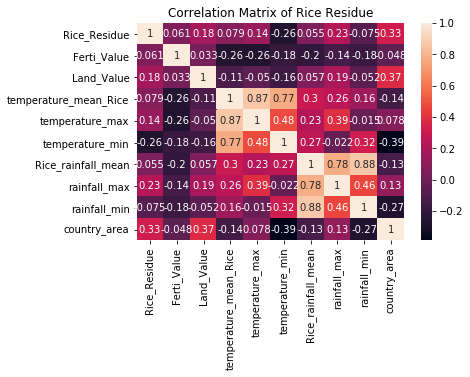

In [54]:
#do prediction
#do coefficient matrix
rice_df= pd.DataFrame(rice18_g4,columns=['Rice_Residue','Ferti_Value',"Land_Value","temperature_mean_Rice",
                                             "temperature_max","temperature_min","Rice_rainfall_mean","rainfall_max","rainfall_min","country_area"])
corrMatrix = rice_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation Matrix of Rice Residue")
plt.show() 

In [55]:
#X=rice_df[['Ferti_Value',"Land_Value","temperature_mean_Rice","temperature_max","temperature_min","Rice_rainfall_mean","rainfall_min","country_area"]]
X=rice_df[["Land_Value","temperature_mean_Rice","temperature_max","temperature_min","rainfall_max","country_area"]]
y=rice_df[['Rice_Residue']]

In [56]:
import statsmodels.api as sm
y= np.array(y) # define output/dependant variable
# Note the difference in argument order
lm = sm.OLS(y, X).fit()
#lm1.summary()
#evaluation
lm_pre_y = lm.predict(X)
print("Ordinary Least Square model:")
#MAE
#print("mean absolute error:", metrics.mean_absolute_error(y_test.values,lm_pre_y.values))
#MSE
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,lm_pre_y))) 

Ordinary Least Square model:
root mean squared error: 16416086.892875655


In [57]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.360
Model:                            OLS   Adj. R-squared (uncentered):              0.343
Method:                 Least Squares   F-statistic:                              20.72
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    3.23e-19
Time:                        02:05:01   Log-Likelihood:                         -4093.4
No. Observations:                 227   AIC:                                      8199.
Df Residuals:                     221   BIC:                                      8219.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Land_Value                3.8614      3.737      1.033      0.303      -3.504      11.227
temperature_mean_Rice  3.144e+06   4.49e+05      7.003      0.000    2.26e+06    4.03e+06
temperature_max       -1.665e+06   3.13e+05     -5.315      0.000   -2.28e+06   -1.05e+06
temperature_min       -1.575e+06      2e+05     -7.878      0.000   -1.97e+06   -1.18e+06
rainfall_max           1014.9061    943.487      1.076      0.283    -844.477    2874.289
country_area              1.9480      0.761      2.558      0.011       0.447       3.449
==============================================================================
Omnibus:                      262.913   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16839.622
Skew:                           4.623   Prob(JB):                         0.00
Kurtosis:                      44.169   Cond. No.                     9.48e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
#lasso regression
import pandas as pd
import numpy as np
from sklearn import model_selection
#from sklearn.linear_model import LassoCV
from sklearn import linear_model
#Lambdas=np.logspace(-5,2,200)
lasso=linear_model.Lasso()
lasso.fit(X,y)
#print(lasso_cv.alpha_)
lasso_pred=lasso.predict(X)
MSE=mean_squared_error(y,lasso_pred)
print("RMSE:",sqrt(MSE))

RMSE: 16370061.580205284


In [59]:
#R-squared
lasso.score(X,y)

0.33508251242217757

In [60]:
#MLP regressor
regr = MLPRegressor(random_state=1, max_iter=500).fit(X, y)
#predict
mlp_pre_y =regr.predict(X)

In [61]:
print("root mean squared error:", sqrt(metrics.mean_squared_error(y,mlp_pre_y)))
## R^2
print("R^2 :",regr.score(X,y))

root mean squared error: 19064856.327320535
R^2 : 0.09815022239685967


In [62]:
#spatial error model

In [63]:
rice_dfg= gpd.GeoDataFrame(rice18_g4,columns=['Rice_Residue',"Land_Value","temperature_mean_Rice","temperature_max","temperature_min","rainfall_max","country_area","geometry"])
w_queeng = Queen.from_dataframe(rice_dfg) 

In [64]:
y_lag=np.array(rice_dfg["Rice_Residue"].values)
y_lag.shape = (len(y_lag),1)

In [65]:
X_lag= []
X_lag.append(rice_df["Land_Value"].values) 
X_lag.append(rice_df["temperature_mean_Rice"].values)
X_lag.append(rice_df["temperature_max"].values)
X_lag.append(rice_df["temperature_min"].values)
X_lag.append(rice_df["rainfall_max"].values)
X_lag.append(rice_df["rainfall_min"].values)
X_lag.append(rice_df["country_area"].values)
X_lag = np.array(X_lag).T

In [66]:
from pysal.model.spreg import ML_Error
spat_err = ML_Error(y_lag,X_lag,w_queeng, name_y='Rice_Residue', 
                  name_x=["Land_Value","temperature_mean_Rice","temperature_max","temperature_min","rainfall_max","country_area"],
                  name_w='w_queeng', name_ds='Rice_Residue')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :Rice_Residue
Weights matrix      :    w_queeng
Dependent Variable  :Rice_Residue                Number of Observations:         227
Mean dependent var  :4246037.4861                Number of Variables   :           8
S.D. dependent var  :20119868.8069                Degrees of Freedom    :         219
Pseudo R-squared    :      0.3173
Sigma-square ML     :249810557878372.344                Log likelihood        :   -4086.650
S.E of regression   :15805396.480                Akaike info criterion :    8189.300
                                                 Schwarz criterion     :    8216.699

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------

In [67]:
from sklearn.metrics import mean_squared_error as mse
sqrt(mse(y, spat_err.predy.flatten()))

16655972.424852083

In [68]:
#projection for 2030
#add temperature change
rice_dfg["temperature_mean_Rice_2030"]=rice_dfg["temperature_mean_Rice"]+0.597
rice_dfg["temperature_max_2030"]=rice_dfg["temperature_max"]+0.597
rice_dfg["temperature_min_2030"]=rice_dfg["temperature_min"]+0.597

In [69]:
X_2030=rice_dfg[["Land_Value","temperature_mean_Rice_2030","temperature_max_2030","temperature_min_2030","rainfall_max","country_area"]]

In [70]:
y_pre_2030=lasso.predict(X_2030)
#y_pre_2030

In [71]:
for i in range(0,len(y_pre_2030)):
    if y_pre_2030[i]<0:
         y_pre_2030[i]=(-1)* y_pre_2030[i]
#y_pre_2030

In [72]:
rice_dfg["Rice_Residue_2030"]=y_pre_2030

Text(0.5, 1, 'Rice Residue Quantity (2030)')

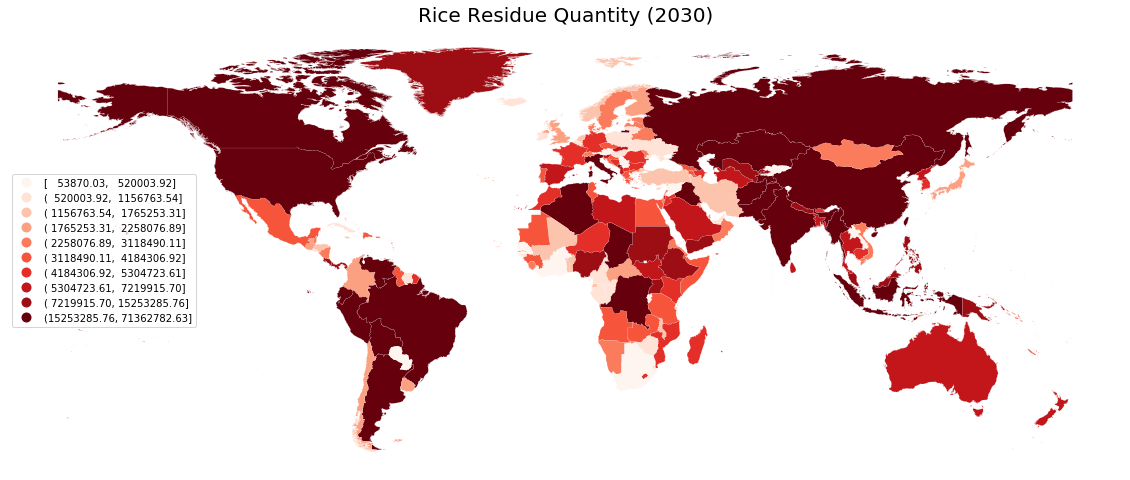

In [73]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
rice_dfg.plot(column='Rice_Residue_2030',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,               
       )
ax.set_axis_off()
ax.set_title("Rice Residue Quantity (2030)", fontsize=20)

In [74]:
#projection for 2040
#add temperature change
rice_dfg["temperature_mean_Rice_2040"]=rice_dfg["temperature_mean_Rice"]+0.851
rice_dfg["temperature_max_2040"]=rice_dfg["temperature_max"]+0.851
rice_dfg["temperature_min_2040"]=rice_dfg["temperature_min"]+0.851

In [75]:
X_2040=rice_dfg[["Land_Value","temperature_mean_Rice_2040","temperature_max_2040","temperature_min_2040","rainfall_max","country_area"]]

In [76]:
y_pre_2040=lasso.predict(X_2040)

In [77]:
for i in range(0,len(y_pre_2040)):
    if y_pre_2040[i]<0:
         y_pre_2040[i]=(-1)* y_pre_2040[i]

In [78]:
rice_dfg["Rice_Residue_2040"]=y_pre_2040

Text(0.5, 1, 'Rice Residue Quantity(2040)')

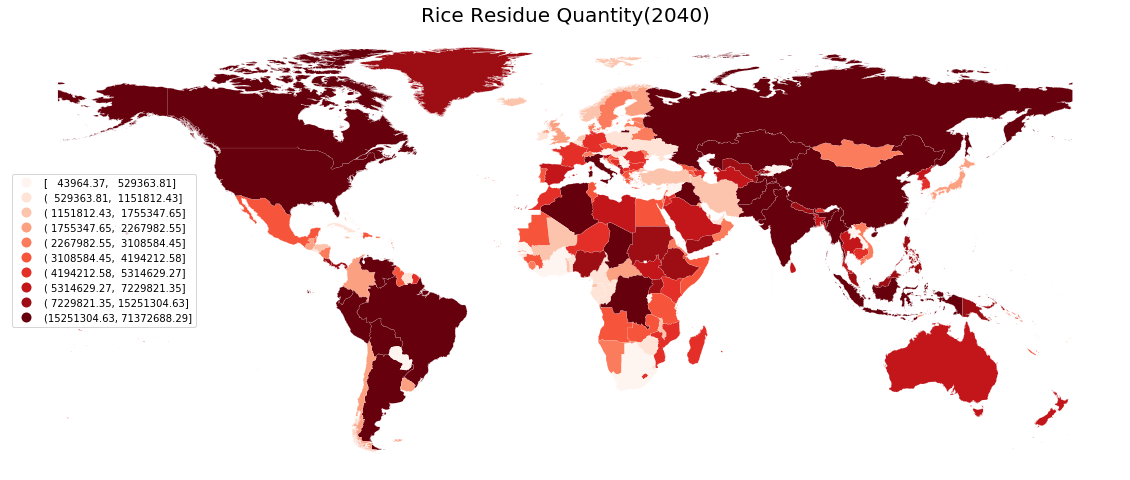

In [79]:
#visualize
fig, ax = plt.subplots(figsize=(20, 15))
rice_dfg.plot(column='Rice_Residue_2040',scheme='quantiles',k=10, 
         cmap=plt.cm.Reds, alpha=1, legend=True,legend_kwds=dict(loc='center left'),
         edgecolor='w', linewidth=0.1,ax=ax,
               
       )
ax.set_axis_off()
ax.set_title("Rice Residue Quantity(2040)", fontsize=20)

In [80]:
#2030
#Cellulose
rice_dfg["Cellulose_2030"]=rice_dfg["Rice_Residue_2030"]*0.36
#Hemicellulose
rice_dfg["Hemicellulose_2030"]=rice_dfg["Rice_Residue_2030"]*0.24
#lignin
rice_dfg["Lignin_2030"]=rice_dfg["Rice_Residue_2030"]*0.41

In [81]:
#2040
#Cellulose
rice_dfg["Cellulose_2040"]=rice_dfg["Rice_Residue_2040"]*0.36
#Hemicellulose
rice_dfg["Hemicellulose_2040"]=rice_dfg["Rice_Residue_2040"]*0.24
#lignin
rice_dfg["Lignin_2040"]=rice_dfg["Rice_Residue_2040"]*0.41

In [82]:
rice_dfg["Country Code"]=rice18_g3['Country Code']

In [83]:
rice_dfg.to_csv("dataset/protein/rice_protein.csv",columns=["Cellulose_2030","Hemicellulose_2030","Lignin_2030",
                                                                 "Cellulose_2040","Hemicellulose_2040","Lignin_2040",
                                                                 "Country Code"])

In [84]:
diff_2030=rice_dfg["Rice_Residue_2030"]-rice_dfg["Rice_Residue"]
diff_2040=rice_dfg["Rice_Residue_2040"]-rice_dfg["Rice_Residue"]

In [85]:
diff_2040

0      1.995625e+07
1      6.868205e+06
2      1.875387e+07
3      5.810336e+06
4      6.467783e+06
5      3.889687e+06
6      2.026961e+06
7      2.023150e+06
8      2.882991e+07
9      3.892476e+06
10     6.631235e+06
11     6.437571e+06
12     3.578653e+05
13     4.622026e+06
14     1.404906e+06
15     9.274108e+05
16    -4.914482e+07
17     8.811124e+05
18     2.312507e+06
19     6.758774e+05
20     2.422808e+06
21     6.838458e+05
22     1.663412e+06
23     4.771269e+06
24     5.132110e+07
25     5.042322e+06
26     3.386990e+05
27     1.844470e+07
28     1.944624e+06
29     1.068078e+07
30     4.136017e+06
31    -6.993489e+04
32     1.460182e+05
33     1.897304e+06
34    -5.974761e+06
35     5.550057e+05
36     2.615928e+07
37     1.403286e+06
38     2.069030e+06
39     1.506343e+07
40     1.562545e+06
41    -1.536251e+08
42     1.835960e+06
43    -1.963704e+07
44    -1.158877e+06
45     3.609577e+05
46     8.349509e+05
47     4.283168e+06
48     7.937132e+06
49    -1.564905e+06


In [86]:
#value in 2030 larger than the value in 2018
diff_2030 = np.array(diff_2030.values>0 ).sum()
diff_2030

193

In [87]:
diff_2040 = np.array(diff_2040.values>0 ).sum()
diff_2040

193